In [7]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import shap

# Keep charts tidy and results reproducible
plt.style.use("seaborn-v0_8")
np.random.seed(42)


def evaluate_regression(y_true, y_pred, num_features, model_name="Model"):
    """Compute the same stats every notebook uses so comparisons stay fair."""
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_true) - 1) / (len(y_true) - num_features - 1))
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} R^2: {r2:.3f}")
    print(f"{model_name} Adjusted R^2: {adj_r2:.3f}")
    print(f"{model_name} MSE: {mse:.3f}")
    print(f"{model_name} RMSE: {rmse:.3f}")
    print(f"{model_name} MAE: {mae:.3f}")
    return {"r2": r2, "rmse": rmse, "mae": mae}


def plot_predictions(y_true, y_pred, title):
    """Mirror the existing scatter plot but for the new model."""
    actual = np.expm1(y_true)
    predicted = np.expm1(y_pred)
    plt.figure(figsize=(6, 6))
    plt.scatter(actual, predicted, alpha=0.6, color="crimson")
    line_start = min(actual.min(), predicted.min())
    line_end = max(actual.max(), predicted.max())
    plt.plot([line_start, line_end], [line_start, line_end], "b-")
    plt.xlabel("Actual SalePrice ($)")
    plt.ylabel("Predicted SalePrice ($)")
    plt.title(title)
    plt.show()


def plot_residuals(y_true, y_pred, title):
    """Histogram of residuals in log space for quick error checks."""
    residuals = y_true - y_pred
    sb.displot(residuals, bins=60, kde=True)
    plt.title(title)
    plt.xlabel("Residual (log dollars)")
    plt.show()


In [2]:
# Load the engineered dataset that every other notebook relies on
data_fin = pd.read_csv("final.csv")
print(f"Prepared dataset shape: {data_fin.shape}")
data_fin.head()


Prepared dataset shape: (2930, 279)


,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,3.044522,4.955827,10.366309,6,1.791759,7.581210,1960,4.727388,6.461468,0.000000,...,False,False,False,True,False,False,False,False,True,False
1,3.044522,4.394449,9.360741,5,1.945910,7.581720,1961,0.000000,6.150603,4.976734,...,False,False,False,True,False,False,False,False,True,False
2,3.044522,4.406719,9.565775,6,1.945910,7.580189,1958,4.691348,6.828712,0.000000,...,False,False,False,True,False,False,False,False,True,False
3,3.044522,4.543295,9.320181,7,1.791759,7.585281,1968,0.000000,6.971669,0.000000,...,False,False,False,True,False,False,False,False,True,False
4,4.110874,4.317488,9.534668,5,1.791759,7.599902,1998,0.000000,6.674561,0.000000,...,False,False,False,True,False,False,False,False,True,False


In [3]:
# Separate features from the log-transformed SalePrice target
X = data_fin.drop('SalePrice', axis=1)
y = data_fin['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training rows: {x_train.shape[0]}, Testing rows: {x_test.shape[0]}, Features: {x_train.shape[1]}")


Training rows: 2344, Testing rows: 586, Features: 278


Basic Lasso R^2: 0.922
Basic Lasso Adjusted R^2: 0.852
Basic Lasso MSE: 0.014
Basic Lasso RMSE: 0.120
Basic Lasso MAE: 0.073
Basic Lasso 5-fold CV R^2: 0.891 ± 0.021


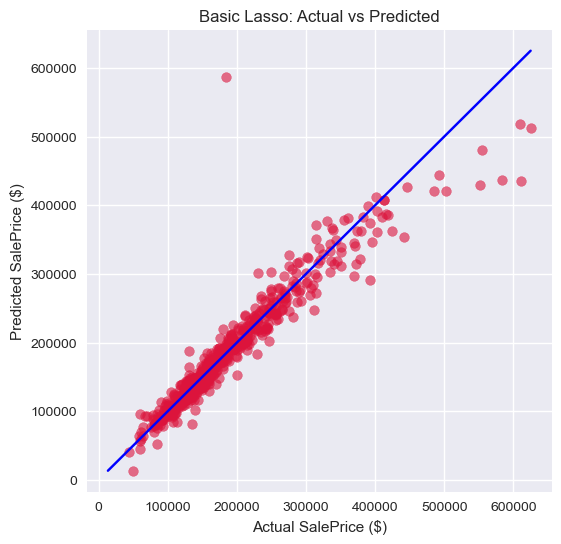

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


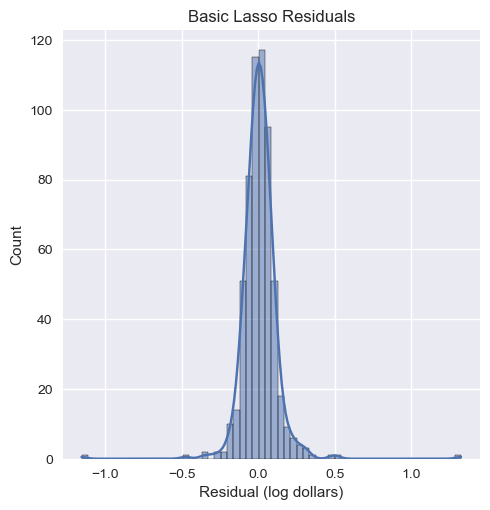

In [ ]:
# Train the basic Lasso model with feature scaling
basic_scaler = StandardScaler(with_mean=False)
x_train_basic = basic_scaler.fit_transform(x_train)
x_test_basic = basic_scaler.transform(x_test)

lasso_basic = Lasso(alpha=0.001, max_iter=5000, random_state=42)
lasso_basic.fit(x_train_basic, y_train)

basic_pred = lasso_basic.predict(x_test_basic)
_ = evaluate_regression(y_test, basic_pred, x_test.shape[1], "Basic Lasso")

# Run cross-validation to assess model stability
basic_pipeline = Pipeline([
    ("scale", StandardScaler(with_mean=False)),
    ("lasso", Lasso(alpha=0.001, max_iter=5000, random_state=42))
])
cv_scores_basic = cross_val_score(basic_pipeline, X, y, scoring="r2", cv=5)
print(f"Basic Lasso 5-fold CV R^2: {cv_scores_basic.mean():.3f} ± {cv_scores_basic.std():.3f}")

plot_predictions(y_test, basic_pred, "Basic Lasso: Actual vs Predicted")
plot_residuals(y_test, basic_pred, "Basic Lasso Residuals")


Best alpha from CV: 0.00281
Tuned Lasso R^2: 0.926
Tuned Lasso Adjusted R^2: 0.859
Tuned Lasso MSE: 0.014
Tuned Lasso RMSE: 0.117
Tuned Lasso MAE: 0.073
Tuned Lasso 5-fold CV R^2: 0.896 ± 0.024


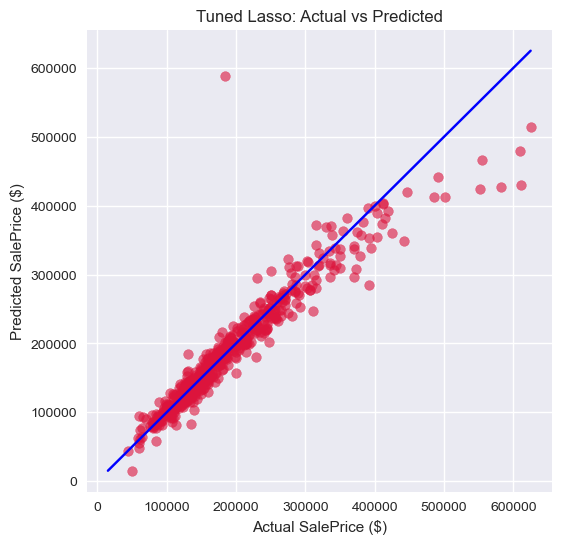

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


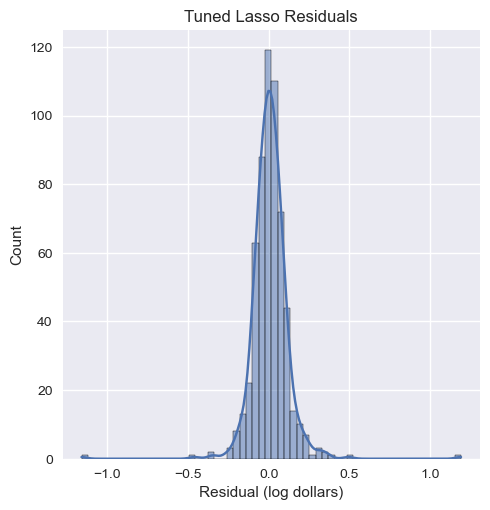

In [ ]:
# Train tuned Lasso model using cross-validation to find best alpha
alpha_grid = np.logspace(-4, -1, 30)
lasso_cv = LassoCV(alphas=alpha_grid, cv=5, random_state=42, n_jobs=-1, max_iter=10000)
lasso_cv.fit(x_train_basic, y_train)

print(f"Best alpha from CV: {lasso_cv.alpha_:.5f}")

tuned_pred = lasso_cv.predict(x_test_basic)
_ = evaluate_regression(y_test, tuned_pred, x_test.shape[1], "Tuned Lasso")

# Run cross-validation to assess model stability
tuned_pipeline = Pipeline([
    ("scale", StandardScaler(with_mean=False)),
    ("lasso", Lasso(alpha=lasso_cv.alpha_, max_iter=10000, random_state=42))
])
cv_scores_tuned = cross_val_score(tuned_pipeline, X, y, scoring="r2", cv=5)
print(f"Tuned Lasso 5-fold CV R^2: {cv_scores_tuned.mean():.3f} ± {cv_scores_tuned.std():.3f}")

plot_predictions(y_test, tuned_pred, "Tuned Lasso: Actual vs Predicted")
plot_residuals(y_test, tuned_pred, "Tuned Lasso Residuals")


/var/folders/p7/hb0z_16573l2434bm7ym41cc0000gn/T/ipykernel_10834/3350762605.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X.iloc[test_idx], plot_type="bar")


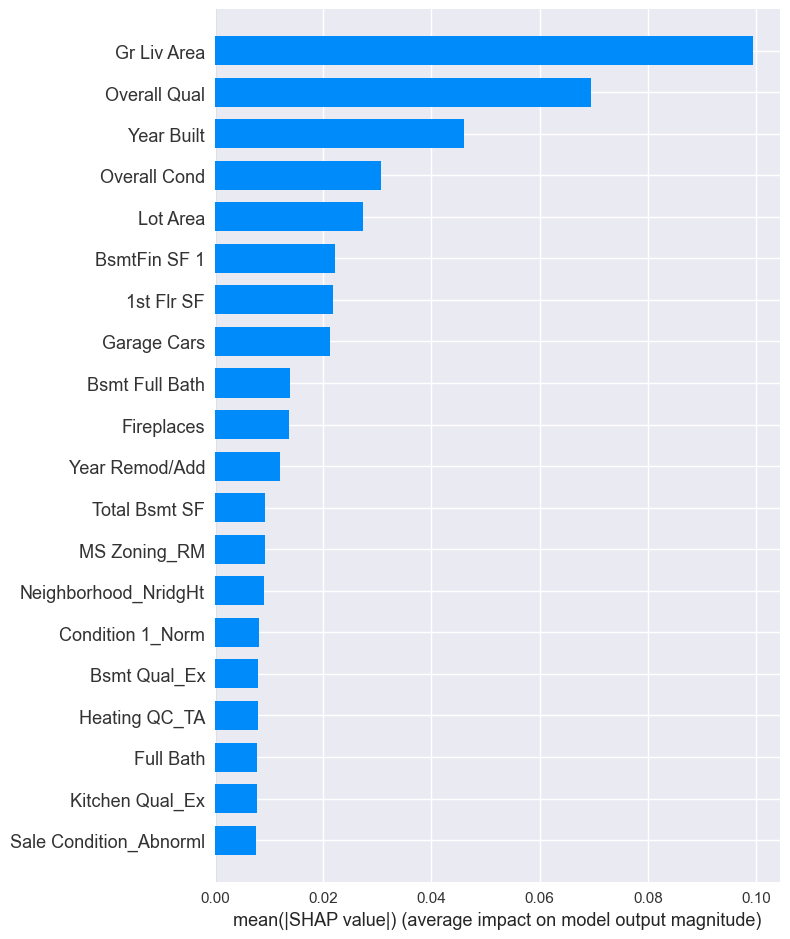

In [6]:
# SHAP overview: highlight which engineered inputs Lasso keeps
background_size = min(200, x_train_basic.shape[0])
background_idx = np.random.choice(x_train_basic.shape[0], background_size, replace=False)
background_data = x_train_basic[background_idx]

explainer = shap.LinearExplainer(lasso_cv, background_data, feature_names=X.columns)

test_size = min(200, x_test_basic.shape[0])
test_idx = np.random.choice(x_test_basic.shape[0], test_size, replace=False)
shap_values = explainer.shap_values(x_test_basic[test_idx])

shap.summary_plot(shap_values, X.iloc[test_idx], plot_type="bar")
